**LABORATORIO DE ETL: ANÁLISIS DE VENTAS DE ELECTRODOMÉSTICOS EN COLOMBIA**

*Objetivo del laboratorio*

El objetivo de este laboratorio es que los estudiantes practiquen habilidades clave de ETL y análisis exploratorio de datos. Utilizarán un dataset que contiene información sobre compras de clientes de electrodomésticos en Colombia.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import glob
import os
from dateutil.parser import parse
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
print("="*50)
print("1. EXTRACCIÓN DE DATOS")
print("="*50)

1. EXTRACCIÓN DE DATOS


In [ ]:
# 1.Cargar el dataset desde un archivo Excel (Dataset_Clientes_Colombia.xlsx)
df = pd.read_excel('Dataset_Clientes_Colombia.xlsx')
print(f"Archivo cargado exitosamente. Dimensiones: {df.shape}")


Archivo cargado exitosamente. Dimensiones: (11275, 9)


In [ ]:
# Mostramos las primeras filas del DataFrame
print("\nPrimeras filas del DataFrame:")
print(df.head())


Primeras filas del DataFrame:
  ID Compra    Nombre   Apellido Electrodoméstico  Cantidad  Valor Unitario  \
0  CL-00001    Marcia      PARRA           Nevera       5.0         1800000   
1  CL-00002   Alfonso       ROMA          Plancha       1.0          150000   
2  CL-00003       NaN     DUE%AS  Horno eléctrico       3.0          500000   
3  CL-00004   Gonzalo  SEBASTIÁN        Licuadora       3.0          250000   
4  CL-00005  Ambrosio       PRAT         Lavadora       5.0         1500000   

   Valor Total Fecha Compra Hora Compra  
0      9000000   2023-07-12    03:27:54  
1       150000   2023-01-16    04:34:05  
2      1500000   2022-09-21    20:18:45  
3       750000   2024-05-23    15:39:00  
4      7500000   2022-09-08    13:57:58  


**# 2. Identificar y contar:**

In [ ]:
# Valores nulos
print("\nValores nulos en el DataFrame:")
print(df.isnull().sum())


Valores nulos en el DataFrame:
ID Compra            0
Nombre              21
Apellido            20
Electrodoméstico    21
Cantidad            10
Valor Unitario       0
Valor Total          0
Fecha Compra         0
Hora Compra          0
dtype: int64


In [ ]:
# valores vacios
print("\nValores vacíos en el DataFrame:")
print(df.isna().sum())


Valores vacíos en el DataFrame:
ID Compra            0
Nombre              21
Apellido            20
Electrodoméstico    21
Cantidad            10
Valor Unitario       0
Valor Total          0
Fecha Compra         0
Hora Compra          0
dtype: int64


In [ ]:
#Filas duplicadas
print("\nFilas duplicadas en el DataFrame:")
print(df.duplicated().sum())


Filas duplicadas en el DataFrame:
0


**3. Verificar formatos inconsistentes en:**

In [ ]:
#formatos inconsistentes en fecha Compra
print("\nFormato inconsistente en la columna 'Fecha Compra':")
print(df['Fecha Compra'].apply(lambda x: not isinstance(x, datetime)).sum())


Formato inconsistente en la columna 'Fecha Compra':
11275


In [ ]:
#formatos inconsistentes en Nombre y Apellido (mayúsculas, símbolos)
print("\nFormato inconsistente en las columnas 'Nombre' y 'Apellido':")
nombre_problemas = df["Nombre"].dropna().apply(lambda x: bool(re.search(r'[^a-zA-ZáéíóúÁÉÍÓÚüÜñÑ\s]', str(x)))).sum()
apellido_problemas = df["Apellido"].dropna().apply(lambda x: bool(re.search(r'[^a-zA-ZáéíóúÁÉÍÓÚüÜñÑ\s]', str(x)))).sum()
print(nombre_problemas)
print(apellido_problemas)


Formato inconsistente en las columnas 'Nombre' y 'Apellido':
42
466


**Otras inconsistencias a verificar**

In [ ]:
# Verificar formato de ID
print("\nVerificación del formato de ID Compra:")
patron_id = r'^CL-\d{5}$'
ids_invalidos = df[~df['ID Compra'].str.match(patron_id)]

if len(ids_invalidos) > 0:
    print(f"Se encontraron {len(ids_invalidos)} IDs con formato inválido:")
    print(ids_invalidos[['ID Compra']])
else:
    print("✓ Todos los IDs siguen el formato esperado (CL-XXXXX)")


Verificación del formato de ID Compra:
✓ Todos los IDs siguen el formato esperado (CL-XXXXX)


In [ ]:
# Verificar inconsistencias en valores numéricos (Cantidad)
print("\nVerificación de valores inconsistentes en Cantidad:")
cantidades_negativas = df[df['Cantidad'] <= 0]
print(len(cantidades_negativas))


Verificación de valores inconsistentes en Cantidad:
0


In [ ]:
# Verificar consistencia entre Valor Unitario y Valor Total
print("\nVerificación de consistencia entre Valor Unitario y Valor Total:")
df['Valor Total Calculado'] = df['Valor Unitario'] * df['Cantidad']
df['Diferencia'] = abs(df['Valor Total'] - df['Valor Total Calculado'])
valores_inconsistentes = df[df['Diferencia'] > 1]  # Tolerancia de 1 peso por redondeo

if len(valores_inconsistentes) > 0:
    print(f"Se encontraron {len(valores_inconsistentes)} registros con inconsistencias entre Valor Unitario y Valor Total:")
    print(valores_inconsistentes[['ID', 'Valor Unitario', 'Cantidad', 'Valor Total', 'Valor Total Calculado', 'Diferencia']])
else:
    print("✓ Todos los valores totales son consistentes con la fórmula: Valor Total = Valor Unitario × Cantidad")



Verificación de consistencia entre Valor Unitario y Valor Total:
✓ Todos los valores totales son consistentes con la fórmula: Valor Total = Valor Unitario × Cantidad


In [ ]:
# Verificar formato de Hora Compra
print("\nVerificación del formato de Hora Compra:")
patron_hora = r'^([01]\d|2[0-3]):([0-5]\d):([0-5]\d)$'
horas_invalidas = df[~df['Hora Compra'].str.match(patron_hora)]
print(len(horas_invalidas))


Verificación del formato de Hora Compra:
0


**TRANSFORMACION**

In [ ]:
# 1. Limpiar nombres y apellidos
#sacamos una copia del df original
df_original = df.copy()

def limpiar_texto(texto):
    if pd.isna(texto):
        return texto
    texto_limpio = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚüÜñÑ\s]', '', str(texto))
    texto_limpio = texto_limpio.strip().title()

    return texto_limpio
# Reemplazar "%" por "ñ" en los apellidos
df["Apellido"] = df["Apellido"].str.replace("%", "ñ", regex=False)
# Aplicar limpieza a nombres y apellidos
df['Nombre'] = df['Nombre'].apply(limpiar_texto)
df['Apellido'] = df['Apellido'].apply(limpiar_texto)
print(df[['Nombre', 'Apellido']].head(8))
# Guardar DataFrame para la siguiente celda del NoteBook
df.to_pickle('df_limpio_temp.pkl')

     Nombre   Apellido
0    Marcia      Parra
1   Alfonso       Roma
2       NaN     Dueñas
3   Gonzalo  Sebastián
4  Ambrosio       Prat
5    Roldán      Elías
6    Amando      Tovar
7    Haydée    Cabrera


In [ ]:
# 2. Normalizar fechas
# Cargar el DataFrame de la celda anterior
try:
    df = pd.read_pickle('df_limpio_temp.pkl')
except:
    print("Por favor, ejecuta la celda anterior primero")

def normalizar_fecha(fecha_str):
    if pd.isna(fecha_str):
        return None

    fecha_str = str(fecha_str).strip()

    try:
        # Primero intenta con dateutil, que detecta formato automáticamente
        return parse(fecha_str, dayfirst=None, fuzzy=True)
    except:
        try:
            # Si falla, intenta con pandas (modo mixed)
            return pd.to_datetime(fecha_str, format='mixed', errors='raise')
        except:
            try:
                # Si sigue fallando, intenta con formato día primero
                return parse(fecha_str, dayfirst=True, fuzzy=True)
            except:
                try:
                    # Intenta limpiar caracteres extraños y reintentar
                    fecha_limpia = re.sub(r'[^\w\s/-]', '', fecha_str)
                    return parse(fecha_limpia, fuzzy=True)
                except:
                    print(f"No se pudo convertir la fecha: {fecha_str}")
                    return None

# Aplicar la función a la columna de fechas
df['Fecha Compra'] = df['Fecha Compra'].apply(normalizar_fecha)

# Identificar filas con fechas no convertidas
filas_con_fechas_nulas = df[df['Fecha Compra'].isna()]
print(f"Número de filas con fechas que no se pudieron convertir: {len(filas_con_fechas_nulas)}")

# Guardar el DataFrame limpio
df.to_pickle('df_limpio_temp.pkl')

Número de filas con fechas que no se pudieron convertir: 0


In [ ]:
# Comprobamos conversion de ocurrencias de fechas en distintos formatos
ids_a_filtrar = ["CL-02615", "CL-06360", "CL-06408", "CL-07074", "CL-07323", "CL-08971"]
df_filtrado = df[df["ID Compra"].isin(ids_a_filtrar)]
print(df_filtrado)

     ID Compra     Nombre   Apellido Electrodoméstico  Cantidad  \
2614  CL-02615       Olga        Tur          Plancha       5.0   
6359  CL-06360   Pacífica      Roman          Plancha       5.0   
6407  CL-06408     Wálter      Marti       Microondas       3.0   
7073  CL-07074  Prudencio  Capdevila         Cafetera       4.0   
7322  CL-07323      Alejo      Durán         Cafetera       3.0   
8970  CL-08971   Evaristo   Vizcaíno       Ventilador       3.0   

      Valor Unitario  Valor Total Fecha Compra Hora Compra  
2614          150000       750000   2022-07-23    08:37:52  
6359          150000       750000   2022-02-05    16:03:08  
6407          400000      1200000   2024-11-03    13:11:59  
7073          300000      1200000   2024-08-02    12:23:10  
7322          300000       900000   2023-01-29    13:48:14  
8970          200000       600000   2023-04-05    13:25:51  


In [ ]:
#3. Imputar valores nulos
# Cargar el DataFrame de la celda anterior
try:
    df = pd.read_pickle('df_limpio_temp.pkl')
except:
    # Si no existe, ejecutar las celdas anteriores primero
    print("Por favor, ejecuta las celdas anteriores primero")
# Si hay valores nulos en la columna 'Nombre', imputarlos lógicamente
if df['Nombre'].isnull().sum() > 0:
    print("\nImputando valores nulos en 'Nombre':")

    # Ver los registros con nombre nulo
print("Registros con nombre nulo antes de la imputación:")
print(df[df['Nombre'].isnull()][['ID Compra', 'Nombre', 'Apellido', 'Electrodoméstico']])

# Si hay valores nulos en la columna 'Nombre', imputarlos lógicamente
# Imputar valores nulos en 'Nombre'
df['Nombre'] = df.apply(lambda row: row['Apellido'] if pd.isna(row['Nombre']) and not pd.isna(row['Apellido']) else row['Nombre'], axis=1)

# Eliminar filas donde tanto 'Nombre' como 'Apellido' sean nulos
df = df.dropna(subset=['Nombre', 'Apellido', 'Electrodoméstico'], how='all')


Imputando valores nulos en 'Nombre':
Registros con nombre nulo antes de la imputación:
     ID Compra Nombre Apellido Electrodoméstico
2     CL-00003    NaN   Dueñas  Horno eléctrico
321   CL-00322    NaN      NaN              NaN
856   CL-00857    NaN      NaN              NaN
907   CL-00908    NaN      NaN              NaN
1061  CL-01062    NaN      NaN              NaN
1078  CL-01079    NaN      NaN              NaN
1311  CL-01312    NaN      NaN              NaN
1343  CL-01344    NaN      NaN              NaN
2009  CL-02010    NaN      NaN              NaN
3355  CL-03356    NaN      NaN              NaN
4808  CL-04809    NaN      NaN              NaN
5623  CL-05624    NaN      NaN              NaN
5638  CL-05639    NaN      NaN              NaN
5800  CL-05801    NaN      NaN              NaN
6323  CL-06324    NaN      NaN              NaN
8534  CL-08535    NaN      NaN              NaN
9317  CL-09318    NaN      NaN              NaN
9556  CL-09557    NaN      NaN              NaN


In [ ]:
# Comprobamos conversion de ocurrencias de nombres NaN
ids_a_filtrar = ["CL-00003", "CL-00322", "CL-00857", "CL-00908", "CL-01062","CL-01079","CL-01312","CL-01344","CL-02010","CL-03356","CL-04809","CL-05624","CL-05639","CL-05801","CL-06324","CL-08535","CL-09318","CL-09557","CL-09616","CL-09670","CL-09887"]
df_filtrado = df[df["ID Compra"].isin(ids_a_filtrar)]
print(df_filtrado)

  ID Compra  Nombre Apellido Electrodoméstico  Cantidad  Valor Unitario  \
2  CL-00003  Dueñas   Dueñas  Horno eléctrico       3.0          500000   

   Valor Total Fecha Compra Hora Compra  
2      1500000   2022-09-21    20:18:45  


In [ ]:
# Valores nulos
print("\nValores nulos en el DataFrame:")
print(df.isnull().sum())


Valores nulos en el DataFrame:
ID Compra           0
Nombre              0
Apellido            0
Electrodoméstico    1
Cantidad            0
Valor Unitario      0
Valor Total         0
Fecha Compra        0
Hora Compra         0
dtype: int64


In [ ]:
columnas_con_nulos = df.columns[df.isnull().any()].tolist()
if columnas_con_nulos:
    print(f"\nOtras columnas con valores nulos: {columnas_con_nulos}")

    # Imputar otros valores nulos según corresponda
    for columna in columnas_con_nulos:
      if columna == 'Electrodoméstico':
        df[columna].fillna("Producto Desconocido", inplace=True)
print(f"  - Se imputaron valores nulos en '{columna}' con 'Producto Desconocido'")
# Guardar el DataFrame para la siguiente celda
df.to_pickle('df_limpio_temp.pkl')


Otras columnas con valores nulos: ['Electrodoméstico']
  - Se imputaron valores nulos en 'Electrodoméstico' con 'Producto Desconocido'


<ipython-input-172-69d5595011f1>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[columna].fillna("Producto Desconocido", inplace=True)


In [ ]:
# Cargar el DataFrame de la celda anterior
try:
    df = pd.read_pickle('df_limpio_temp.pkl')
except:
    # Si no existe, ejecutar las celdas anteriores primero
    print("Por favor, ejecuta las celdas anteriores primero")

# Verificar duplicados exactos (todas las columnas)
duplicados_exactos = df.duplicated().sum()
print(f"Duplicados exactos encontrados: {duplicados_exactos}")


Duplicados exactos encontrados: 0


In [ ]:
# Verificar duplicados basados en subconjuntos de columnas
# Por ejemplo, misma persona comprando el mismo producto en la misma fecha
columnas_clave = ['Nombre', 'Apellido', 'Electrodoméstico', 'Fecha Compra', 'Hora Compra']
duplicados_parciales = df.duplicated(subset=columnas_clave).sum()

print(f"\nDuplicados basados en {columnas_clave}: {duplicados_parciales}")

if duplicados_parciales > 0:
    print("\nPosibles duplicados (misma persona, mismo producto, misma fecha):")
    print(df[df.duplicated(subset=columnas_clave, keep=False)].sort_values(by=columnas_clave))

    # Analizar estos duplicados parciales para determinar si son errores o compras legítimas
    print("\nAnálisis de duplicados parciales:")

    # Agrupar para ver las diferencias
    for _, grupo in df[df.duplicated(subset=columnas_clave, keep=False)].groupby(columnas_clave):
        print("\nPosible grupo de duplicados:")
        print(grupo[['ID Compra', 'Nombre', 'Apellido', 'Electrodoméstico', 'Cantidad', 'Fecha Compra', 'Hora Compra']])

        # Verificar si difieren en cantidad (podrían ser compras separadas)
        if grupo['Cantidad'].nunique() > 1:
            print("  → Estos registros difieren en cantidad, podrían ser compras separadas")

        # Verificar si difieren en hora (podrían ser compras separadas)
        if grupo['Hora Compra'].nunique() > 1:
            print("  → Estos registros difieren en hora, podrían ser compras separadas")

        # Si son exactamente iguales en todo excepto en ID, probablemente son duplicados reales
        if (grupo.drop('ID Compra', axis=1).nunique() == 1).all():
            print("  → Estos registros parecen ser duplicados reales (solo difieren en ID)")
            # Conservar solo la primera ocurrencia
            ids_a_eliminar = grupo['ID Compra'].iloc[1:].tolist()
            df = df[~df['ID Compra'].isin(ids_a_eliminar)]
            print(f"  → Se eliminaron los IDs: {ids_a_eliminar}")

# Contar registros después de eliminar duplicados
print(f"\nRegistros finales después de eliminar duplicados: {len(df)}")

# Guardar el DataFrame para la siguiente celda
df.to_pickle('df_limpio_temp.pkl')


Duplicados basados en ['Nombre', 'Apellido', 'Electrodoméstico', 'Fecha Compra', 'Hora Compra']: 23

Posibles duplicados (misma persona, mismo producto, misma fecha):
      ID Compra     Nombre    Apellido Electrodoméstico  Cantidad  \
1      CL-00002    Alfonso        Roma          Plancha       1.0   
11251  CL-11252    Alfonso        Roma          Plancha       1.0   
4      CL-00005   Ambrosio        Prat         Lavadora       5.0   
11254  CL-11255   Ambrosio        Prat         Lavadora       5.0   
5753   CL-05754     Azahar    Figueroa         Lavadora       4.0   
11267  CL-11268     Azahar    Figueroa         Lavadora       4.0   
11058  CL-11059   Bautista  Villaverde         Lavadora       5.0   
11272  CL-11273   Bautista  Villaverde         Lavadora       5.0   
1496   CL-01497   Cipriano     Verdugo         Cafetera       4.0   
11268  CL-11269   Cipriano     Verdugo         Cafetera       4.0   
4463   CL-04464       Cruz      Adadia         Lavadora       1.0   
1126

In [ ]:
# Cargar el DataFrame de la celda anterior
try:
    df = pd.read_pickle('df_limpio_temp.pkl')
except:
    # Si no existe, ejecutar las celdas anteriores primero
    print("Por favor, ejecuta las celdas anteriores primero")

#df['Fecha Compra'] = pd.to_datetime(df['Fecha Compra'])

# 1. Crear columna de año de compra
df['Año Compra'] = df['Fecha Compra'].dt.year
print("Columna 'Año Compra' creada")

# 2. Crear columna de mes de compra
df['Mes Compra'] = df['Fecha Compra'].dt.month
print("Columna 'Mes Compra' creada")

# También agregar el nombre del mes para mayor claridad
df['Nombre Mes'] = df['Fecha Compra'].dt.month_name()
print("Columna 'Nombre Mes' creada")

# 3. Crear columna de hora de compra (solo hora)
df['Hora'] = df['Hora Compra'].str.split(':').str[0].astype(int)
print("Columna 'Hora' creada")

# 4. Crear columna de valor medio por unidad
df['valor medio por unidad'] = df['Valor Total'] / df['Cantidad']

# Mostrar las primeras filas con las nuevas columnas
print("\nDataFrame con las nuevas columnas:")
print(df[['ID Compra', 'Año Compra', 'Mes Compra', 'Nombre Mes', 'Hora']].head())

# Guardar el DataFrame para la siguiente celda
df.to_pickle('df_limpio_temp.pkl')

Columna 'Año Compra' creada
Columna 'Mes Compra' creada
Columna 'Nombre Mes' creada
Columna 'Hora' creada

DataFrame con las nuevas columnas:
  ID Compra  Año Compra  Mes Compra Nombre Mes  Hora
0  CL-00001        2023           7       July     3
1  CL-00002        2023           1    January     4
2  CL-00003        2022           9  September    20
3  CL-00004        2024           5        May    15
4  CL-00005        2022           9  September    13


In [ ]:
# 6. Clasificar electrodomésticos por categoría
try:
    df = pd.read_pickle('df_limpio_temp.pkl')
except:
    # Si no existe, ejecutar las celdas anteriores primero
    print("Por favor, ejecuta las celdas anteriores primero")

categoria_map = {
    'Nevera': 'Cocina', 'Licuadora': 'Cocina', 'Estufa': 'Cocina', 'Cafetera': 'Cocina', 'Horno eléctrico': 'Cocina',
    'Microondas': 'Cocina', 'Lavadora': 'Limpieza', 'Aspiradora': 'Limpieza', 'Secadora': 'Limpieza',
    'Plancha': 'Limpieza', 'Televisor': 'Confort', 'Aire Acondicionado': 'Confort', 'Ventilador': 'Confort'
}
df['Categoría'] = df['Electrodoméstico'].map(categoria_map).fillna('Otros')
print("Columna 'Categoría' creada")

# Guardar el DataFrame para la siguiente celda
df.to_pickle('df_limpio_temp.pkl')

Columna 'Categoría' creada


In [ ]:
# 7.Generar un Excel nuevo con todas las transformaciones realizadas
df.to_pickle('df_procesado.pkl')
try:
    df.to_excel('Dataset_Clientes_Colombia_Procesado.xlsx', index=False)
    print("\nDataFrame final guardado como 'Dataset_Clientes_Colombia_Procesado.xlsx'")
except:
    print("\nNo se pudo guardar el archivo Excel, pero los datos están disponibles en el DataFrame")


DataFrame final guardado como 'Dataset_Clientes_Colombia_Procesado.xlsx'


In [ ]:
# Eliminar archivo temporal
try:
    os.remove('df_limpio_temp.pkl')
except:
    pass

print("\nProcesamiento de datos completado exitosamente!")


Procesamiento de datos completado exitosamente!


**Encontrar hallazgos con Pandas:**

Responde las siguientes 20 preguntas analíticas usando el dataset transformado:

In [ ]:
# 1. Electrodoméstico más vendido por cantidad
electro_mas_vendido = df.groupby("Electrodoméstico")["Cantidad"].sum().idxmax()
print(f"El electrodoméstico más vendido por cantidad es: {electro_mas_vendido}")

El electrodoméstico más vendido por cantidad es: Plancha


In [ ]:
# 2. Electrodoméstico que generó más ingresos
electro_mas_ingresos = df.groupby("Electrodoméstico")["Valor Total"].sum().idxmax()
print(f"El electrodoméstico que generó más ingresos es: {electro_mas_ingresos}")

El electrodoméstico que generó más ingresos es: Nevera


In [ ]:
# 3. Ticket promedio por compra
ticket_promedio = df["Valor Total"].mean()
print(f"El ticket promedio por compra es: {ticket_promedio}")

El ticket promedio por compra es: 2050467.4145299145


In [ ]:
# 4. Compras realizadas por año
compras_por_anio = df["Año Compra"].value_counts().to_dict()
print("Compras realizadas por año:")
print(compras_por_anio)

Compras realizadas por año:
{2024: 3765, 2022: 3739, 2023: 3728}


In [ ]:
# 5. Compras realizadas por mes
compras_por_mes = df["Nombre Mes"].value_counts().to_dict()
print("Compras realizadas por mes:")
print(compras_por_mes)

Compras realizadas por mes:
{'August': 1033, 'January': 1001, 'November': 968, 'October': 944, 'July': 938, 'May': 936, 'December': 933, 'September': 919, 'June': 918, 'March': 906, 'April': 891, 'February': 845}


In [ ]:
# 6. Hora del día con más compras
hora_mas_compras = df["Hora"].value_counts().idxmax()
print(f"La hora del día con más compras es: {hora_mas_compras}")

La hora del día con más compras es: 12


In [ ]:
# 7. Cliente que compró más unidades
cliente_mas_unidades = df.groupby(["Nombre", "Apellido"])["Cantidad"].sum().idxmax()
print(f"El cliente que compró más unidades es: {cliente_mas_unidades}")

El cliente que compró más unidades es: ('Dafne', 'Álvarez')


In [ ]:
# 8. Compras con valor total mayor a $5,000,000
compras_mayores_5M = (df["Valor Total"] > 5000000).sum()
print(f"El número de compras con valor total mayor a $5,000,000 es: {compras_mayores_5M}")

El número de compras con valor total mayor a $5,000,000 es: 1322


In [ ]:
# 9. Media y mediana del Valor Unitario
media_valor_unitario = df["Valor Unitario"].mean()
mediana_valor_unitario = df["Valor Unitario"].median()
print(f"La media del Valor Unitario es: {media_valor_unitario}")
print(f"La mediana del Valor Unitario es: {mediana_valor_unitario}")

La media del Valor Unitario es: 687753.7393162394
La mediana del Valor Unitario es: 400000.0


In [ ]:
# 10. Compras sin nombre de cliente registrado
compras_sin_nombre = df["Nombre"].isna().sum()
print(f"El número de compras sin nombre de cliente registrado es: {compras_sin_nombre}")

El número de compras sin nombre de cliente registrado es: 0


Para la anterior consulta arroja 0 debido a que con anterioridad se realizo una limpieza y transformacion basada en el nombre, 1 de los clientes no registraba nombre y se homologo al apellido, el resto que no registraba nombre se tomaron como registros sin valos ya que no presentaban datos en la mayoria de sus celdas.

Imputando valores nulos en 'Nombre':

Registros con nombre nulo antes de la imputación:

     ID Compra Nombre Apellido Electrodoméstico
    CL-00003    NaN   Dueñas  Horno eléctrico
    CL-00322    NaN      NaN              NaN
    CL-00857    NaN      NaN              NaN
    CL-00908    NaN      NaN              NaN
    CL-01062    NaN      NaN              NaN
    CL-01079    NaN      NaN              NaN
    CL-01312    NaN      NaN              NaN
    CL-01344    NaN      NaN              NaN
    CL-02010    NaN      NaN              NaN
    CL-03356    NaN      NaN              NaN
    CL-04809    NaN      NaN              NaN
    CL-05624    NaN      NaN              NaN
    CL-05639    NaN      NaN              NaN
    CL-05801    NaN      NaN              NaN
    CL-06324    NaN      NaN              NaN
    CL-08535    NaN      NaN              NaN
    CL-09318    NaN      NaN              NaN
    CL-09557    NaN      NaN              NaN
    CL-09616    NaN      NaN              NaN
    CL-09670    NaN      NaN              NaN
    CL-09887    NaN      NaN              NaN

In [ ]:
# 11. Producto más común en compras duplicadas
# Filtrar compras duplicadas
productos_duplicados = df[df.duplicated(subset=["ID Compra"], keep=False)]["Electrodoméstico"].mode()

# Verificar si hay resultados antes de acceder a iloc[0]
if not productos_duplicados.empty:
    print(f"El producto más común en compras duplicadas es: {productos_duplicados.iloc[0]}")
else:
    print("No hay compras duplicadas en el dataset.")


No hay compras duplicadas en el dataset.


In [ ]:
# 12. Relación entre cantidad y valor total (correlación)
correlacion_cantidad_valor = df[["Cantidad", "Valor Total"]].corr().iloc[0,1]
print(f"La correlación entre Cantidad y Valor Total es: {correlacion_cantidad_valor}")

La correlación entre Cantidad y Valor Total es: 0.46508794528856195


In [ ]:
# 13. Número de categorías de electrodomésticos
num_categorias = df["Categoría"].nunique()
print(f"El número de categorías de electrodomésticos es: {num_categorias}")

El número de categorías de electrodomésticos es: 4


In [ ]:
# 14. Categoría que vende más
categoria_mas_vendida = df.groupby("Categoría")["Cantidad"].sum().idxmax()
print(f"La categoría que vende más es: {categoria_mas_vendida}")

La categoría que vende más es: Cocina


In [ ]:
# 15. Meses con más compras (estacionalidad)
meses_mas_compras = df["Nombre Mes"].value_counts().sort_values(ascending=False)
print(f"Los meses con más compras son: {meses_mas_compras}")

Los meses con más compras son: Nombre Mes
August       1033
January      1001
November      968
October       944
July          938
May           936
December      933
September     919
June          918
March         906
April         891
February      845
Name: count, dtype: int64


In [ ]:
# 16. Proporción entre compras de lavadoras y neveras
lavadoras = df[df["Electrodoméstico"] == "Lavadora"]["Cantidad"].sum()
neveras = df[df["Electrodoméstico"] == "Nevera"]["Cantidad"].sum()
proporcion_lavadoras_neveras = lavadoras / neveras if neveras != 0 else "No hay neveras en el dataset"
print(f"La proporción entre compras de lavadoras y neveras es: {proporcion_lavadoras_neveras}")

La proporción entre compras de lavadoras y neveras es: 0.9823269513991163


In [ ]:
# 17. Comparación de compras entre cocina y Confort
compras_cocina = df[df['Categoría'] == 'Cocina'].shape[0]
compras_Confort = df[df['Categoría'] == 'Confort'].shape[0]

print(f"Compras de productos de cocina: {compras_cocina}")
print(f"Compras de productos de Confort: {compras_Confort}")
print(f"Relación cocina vs. Confort: {compras_cocina}/{compras_Confort}")

Compras de productos de cocina: 5638
Compras de productos de Confort: 2178
Relación cocina vs. Confort: 5638/2178


In [ ]:
# 18. Total de productos vendidos
total_productos_vendidos = df["Cantidad"].sum()
print(f"El total de productos vendidos es: {total_productos_vendidos}")

El total de productos vendidos es: 33452.0


In [ ]:
# 19. Promedio de productos por compra
promedio_productos_por_compra = df["Cantidad"].mean()
print(f"Promedio de productos por compra: {promedio_productos_por_compra:.2f} %")

Promedio de productos por compra: 2.98 %


In [ ]:
# 20. Porcentaje de compras con más de una unidad
# Contar compras con más de una unidad
compras_multiple = df[df['Cantidad'] > 1].shape[0]
total_compras = df.shape[0]

# Calcular el porcentaje
porcentaje = (compras_multiple / total_compras) * 100

print(f"Porcentaje de compras con más de una unidad: {porcentaje:.2f} %")

Porcentaje de compras con más de una unidad: 79.55 %


**Preguntas de Negocio**

1. ¿Qué productos debería promocionar la empresa en temporadas altas?

In [ ]:
ventas_por_mes = df.groupby('Nombre Mes')['Valor Total'].sum().sort_values(ascending=False)
temporadas_altas = ventas_por_mes.head(3).index.tolist()

print(f"Temporadas altas identificadas: {temporadas_altas}")

# Productos más vendidos en temporadas altas (por cantidad)
productos_temporada_alta = df[df['Nombre Mes'].isin(temporadas_altas)]
productos_populares = productos_temporada_alta.groupby('Electrodoméstico')['Cantidad'].sum().sort_values(ascending=False)

print("\nProductos más vendidos en temporadas altas (por cantidad):")
print(productos_populares.head(5))

# Productos más rentables en temporadas altas (por valor total)
productos_rentables = productos_temporada_alta.groupby('Electrodoméstico')['Valor Total'].sum().sort_values(ascending=False)

print("\nProductos más rentables en temporadas altas (por valor total):")
print(productos_rentables.head(5))

Temporadas altas identificadas: ['August', 'November', 'July']

Productos más vendidos en temporadas altas (por cantidad):
Electrodoméstico
Nevera        927.0
Plancha       926.0
Microondas    912.0
Televisor     904.0
Aspiradora    890.0
Name: Cantidad, dtype: float64

Productos más rentables en temporadas altas (por valor total):
Electrodoméstico
Nevera             1668600000
Lavadora           1318500000
Televisor          1084800000
Aspiradora          534000000
Horno eléctrico     405500000
Name: Valor Total, dtype: int64


2. ¿Hay clientes frecuentes o con tickets altos a los que se podría fidelizar?

In [ ]:
cliente_frecuencia = df.groupby(['Nombre', 'Apellido']).size().sort_values(ascending=False)

print("Clientes con mayor frecuencia de compra:")
print(cliente_frecuencia.head(10))

# Análisis de clientes por valor total de compras
cliente_valor = df.groupby(['Nombre', 'Apellido'])['Valor Total'].sum().sort_values(ascending=False)

print("\nClientes con mayor valor total de compras:")
print(cliente_valor.head(10))

# Identificar clientes premium (alta frecuencia y alto valor)
# Primero normalizar ambas métricas
norm_frecuencia = (cliente_frecuencia - cliente_frecuencia.min()) / (cliente_frecuencia.max() - cliente_frecuencia.min())
norm_valor = (cliente_valor - cliente_valor.min()) / (cliente_valor.max() - cliente_valor.min())

# Crear un score combinado
cliente_score = norm_frecuencia + norm_valor

print("\nClientes premium para programa de fidelización:")
print(cliente_score.sort_values(ascending=False).head(15))

Clientes con mayor frecuencia de compra:
Nombre    Apellido  
Isidora   Montserrat    2
Emma      Durán         2
Dulce     Franco        2
Ana       Sandoval      2
Joan      Cifuentes     2
Teresita  Macias        2
Jenny     Cuevas        2
Zaira     Gomis         2
Marina    Beltrán       2
Modesto   Chacón        2
dtype: int64

Clientes con mayor valor total de compras:
Nombre    Apellido 
Pastor    Cifuentes    14400000
Amparo    Artigas      13500000
Cristian  Manrique     12900000
Raúl      Pou          11400000
Dafne     Álvarez      11000000
Áurea     Nicolau       9600000
Agapito   Mínguez       9300000
Joan      Cifuentes     9200000
Abraham   Perera        9000000
Zacarías  Iborra        9000000
Name: Valor Total, dtype: int64

Clientes premium para programa de fidelización:
Nombre      Apellido 
Pastor      Cifuentes    2.000000
Amparo      Artigas      1.936842
Cristian    Manrique     1.894737
Raúl        Pou          1.789474
Dafne       Álvarez      1.761404
Áurea   

3. ¿Vale la pena mantener todos los productos en el portafolio?

In [ ]:
rentabilidad_producto = df.groupby('Electrodoméstico').agg({
    'Cantidad': 'sum',
    'Valor Total': 'sum'
}).sort_values('Valor Total', ascending=False)

# Calcular el porcentaje acumulado de la rentabilidad
rentabilidad_producto['Porcentaje'] = rentabilidad_producto['Valor Total'] / rentabilidad_producto['Valor Total'].sum() * 100
rentabilidad_producto['Porcentaje_Acumulado'] = rentabilidad_producto['Porcentaje'].cumsum()

print("Análisis de rentabilidad por producto:")
print(rentabilidad_producto)

# Identificar productos poco rentables (último 20% de ventas)
productos_poco_rentables = rentabilidad_producto[rentabilidad_producto['Porcentaje_Acumulado'] > 80]

print("\nProductos a considerar revisar o eliminar del portafolio:")
print(productos_poco_rentables)

# Análisis de ventas por categoría
ventas_categoria = df.groupby('Categoría').agg({
    'Cantidad': 'sum',
    'Valor Total': 'sum'
}).sort_values('Valor Total', ascending=False)

print("\nDesempeño por categoría:")
print(ventas_categoria)

Análisis de rentabilidad por producto:
                      Cantidad  Valor Total  Porcentaje  Porcentaje_Acumulado
Electrodoméstico                                                             
Nevera                  3395.0   6111000000   26.533975             26.533975
Lavadora                3335.0   5002500000   21.720866             48.254841
Televisor               3272.0   3926400000   17.048437             65.303278
Aspiradora              3341.0   2004600000    8.703977             74.007255
Horno eléctrico         3183.0   1591500000    6.910296             80.917552
Microondas              3389.0   1355600000    5.886018             86.803570
Cafetera                3344.0   1003200000    4.355897             91.159467
Licuadora               3440.0    860000000    3.734122             94.893588
Ventilador              3241.0    648200000    2.814486             97.708074
Plancha                 3511.0    526650000    2.286715             99.994790
Producto Desconocido     

4.
¿Debería la empresa reforzar su logística en ciertos meses?

Volumen de ventas mensual:
    Año Compra Nombre Mes  ID Compra  Cantidad  Valor Total
0         2022    January        344    1051.0    692700000
1         2022   February        279     836.0    600200000
2         2022      March        289     857.0    595350000
3         2022      April        283     864.0    619750000
4         2022        May        310     942.0    617450000
5         2022       June        290     879.0    593000000
6         2022       July        309     905.0    615350000
7         2022     August        360    1030.0    730350000
8         2022  September        298     843.0    598550000
9         2022    October        326     980.0    693450000
10        2022   November        345    1010.0    643550000
11        2022   December        306     902.0    604850000
12        2023    January        346    1052.0    714050000
13        2023   February        284     872.0    646500000
14        2023      March        294     817.0    561200000
15        202

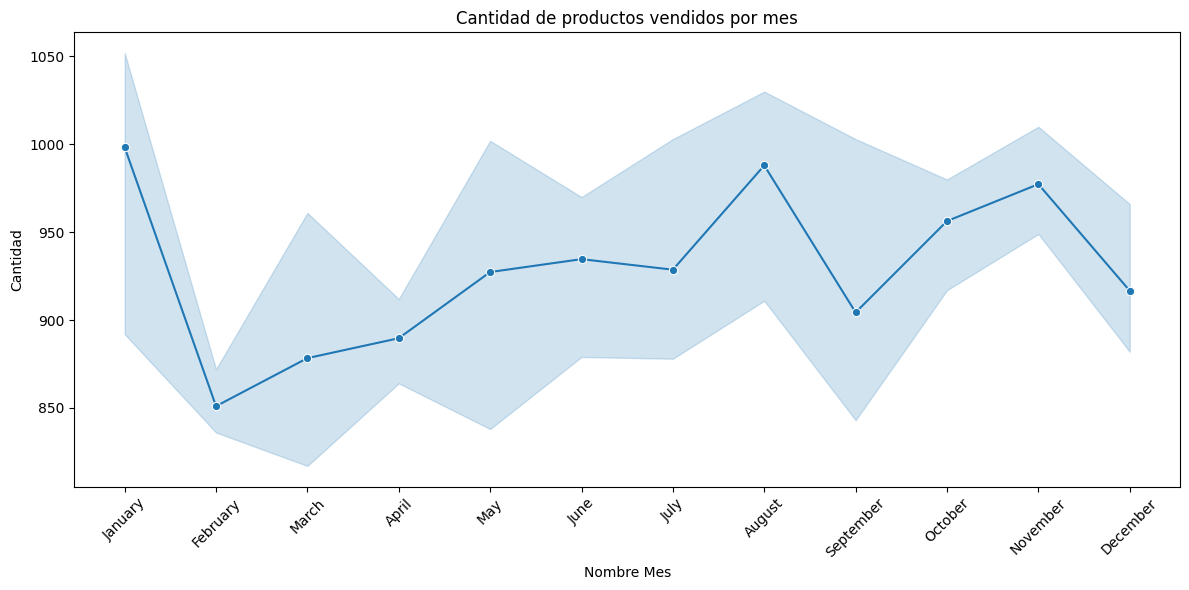

In [ ]:
ventas_mensuales = df.groupby(['Año Compra', 'Mes Compra', 'Nombre Mes']).agg({
    'ID Compra': 'count',
    'Cantidad': 'sum',
    'Valor Total': 'sum'
}).reset_index()

# Asegurar que los meses estén en orden cronológico
meses_orden = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
               'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
ventas_mensuales['Orden_Mes'] = ventas_mensuales['Nombre Mes'].map(meses_orden)
ventas_mensuales = ventas_mensuales.sort_values(['Año Compra', 'Orden_Mes'])

print("Volumen de ventas mensual:")
print(ventas_mensuales[['Año Compra', 'Nombre Mes', 'ID Compra', 'Cantidad', 'Valor Total']])

# Identificar picos de venta que requieren mayor logística
promedio_cantidad = ventas_mensuales['Cantidad'].mean()
picos_venta = ventas_mensuales[ventas_mensuales['Cantidad'] > promedio_cantidad * 1.5]

print("\nMeses con picos de venta (>150% del promedio):")
print(picos_venta[['Año Compra', 'Nombre Mes', 'Cantidad', 'Valor Total']])

# Visualización de tendencias mensuales
plt.figure(figsize=(12, 6))
sns.lineplot(data=ventas_mensuales, x='Nombre Mes', y='Cantidad', marker='o', sort=False)
plt.title('Cantidad de productos vendidos por mes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ventas_mensuales.png')

5. ¿Hay productos que parecen propensos a errores de registro?

In [ ]:
stats_productos = df.groupby('Electrodoméstico').agg({
    'Valor Unitario': ['mean', 'std', 'min', 'max', 'count']
})

# Calcular coeficiente de variación para detectar alta dispersión
stats_productos['CV'] = stats_productos[('Valor Unitario', 'std')] / stats_productos[('Valor Unitario', 'mean')]

print("Análisis de variabilidad en precios unitarios:")
print(stats_productos.sort_values(('CV',), ascending=False))

# Identificar registros sospechosos (precio unitario muy diferente al promedio)
for producto in df['Electrodoméstico'].unique():
    promedio = df[df['Electrodoméstico'] == producto]['Valor Unitario'].mean()
    std = df[df['Electrodoméstico'] == producto]['Valor Unitario'].std()

    # Definir límites (3 desviaciones estándar)
    limite_inferior = max(0, promedio - 3*std)
    limite_superior = promedio + 3*std

    outliers = df[(df['Electrodoméstico'] == producto) &
                 ((df['Valor Unitario'] < limite_inferior) |
                  (df['Valor Unitario'] > limite_superior))]

    if not outliers.empty:
        print(f"\nPosibles errores de registro para {producto}:")
        print(outliers[['ID Compra', 'Electrodoméstico', 'Cantidad', 'Valor Unitario', 'Valor Total']])

# Verificar inconsistencias entre Valor Unitario * Cantidad y Valor Total
df['Valor_Calculado'] = df['Valor Unitario'] * df['Cantidad']
df['Diferencia'] = abs(df['Valor_Calculado'] - df['Valor Total'])

print("\nRegistros con inconsistencias en cálculos de valor:")
inconsistencias = df[df['Diferencia'] > 1]  # Diferencia mayor a 1 para evitar problemas de redondeo
print(inconsistencias[['ID Compra', 'Electrodoméstico', 'Cantidad', 'Valor Unitario', 'Valor Total', 'Valor_Calculado']])

Análisis de variabilidad en precios unitarios:
                     Valor Unitario                                CV
                               mean  std      min      max count     
Electrodoméstico                                                     
Aspiradora                 600000.0  0.0   600000   600000  1121  0.0
Cafetera                   300000.0  0.0   300000   300000  1117  0.0
Horno eléctrico            500000.0  0.0   500000   500000  1082  0.0
Lavadora                  1500000.0  0.0  1500000  1500000  1126  0.0
Licuadora                  250000.0  0.0   250000   250000  1151  0.0
Microondas                 400000.0  0.0   400000   400000  1155  0.0
Nevera                    1800000.0  0.0  1800000  1800000  1133  0.0
Plancha                    150000.0  0.0   150000   150000  1168  0.0
Televisor                 1200000.0  0.0  1200000  1200000  1086  0.0
Ventilador                 200000.0  0.0   200000   200000  1092  0.0
Producto Desconocido      1200000.0  NaN  1

6. ¿Se puede usar esta información para proyecciones de stock?

In [ ]:
ventas_temporales = df.groupby(['Año Compra', 'Mes Compra', 'Nombre Mes'])['Cantidad'].sum().reset_index()
ventas_temporales['Fecha'] = pd.to_datetime(ventas_temporales['Año Compra'].astype(str) + '-' +
                                           ventas_temporales['Mes Compra'].astype(str) + '-01')
ventas_temporales = ventas_temporales.sort_values('Fecha')
ventas_temporales.set_index('Fecha', inplace=True)

# Análisis de estacionalidad (requiere al menos 2 años de datos)
if len(ventas_temporales) >= 24:  # Verificar que haya suficientes datos
    try:
        resultado = seasonal_decompose(ventas_temporales['Cantidad'], model='multiplicative', period=12)
        print("Patrón estacional detectado. Se pueden usar proyecciones estacionales.")
    except:
        print("No se pudo realizar descomposición estacional. Posiblemente faltan datos.")

# Proyección simple para los próximos 3 meses
# Para un dataset pequeño, usamos un enfoque simple
if len(ventas_temporales) < 24:
    media_movil = ventas_temporales['Cantidad'].rolling(window=3).mean()
    proyeccion = media_movil.iloc[-1] if not np.isnan(media_movil.iloc[-1]) else ventas_temporales['Cantidad'].mean()
    print(f"\nProyección simple para próximo mes: {round(proyeccion)} unidades")
else:
    # Para dataset completo, usar modelo más sofisticado
    try:
        modelo = ExponentialSmoothing(ventas_temporales['Cantidad'],
                                    seasonal_periods=12,
                                    trend='add',
                                    seasonal='add').fit()
        pronostico = modelo.forecast(3)
        print("\nProyección para los próximos 3 meses:")
        print(pronostico)
    except:
        print("No se pudo generar un modelo de pronóstico. Revisa la calidad de los datos.")

# Análisis de rotación de inventario por producto
ventas_producto = df.groupby('Electrodoméstico')['Cantidad'].sum().sort_values(ascending=False)
print("\nRotación de productos (cantidad total vendida):")
print(ventas_producto)

# Calcular tasa de ventas diaria promedio
# Primero convertir fechas a datetime
df['Fecha Compra'] = pd.to_datetime(df['Fecha Compra'])
dias_registrados = (df['Fecha Compra'].max() - df['Fecha Compra'].min()).days + 1

tasa_diaria = df.groupby('Electrodoméstico')['Cantidad'].sum() / dias_registrados
print("\nTasa de venta diaria promedio por producto:")
print(tasa_diaria.sort_values(ascending=False))

Patrón estacional detectado. Se pueden usar proyecciones estacionales.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



Proyección para los próximos 3 meses:
2025-01-01    1005.220340
2025-02-01     860.852811
2025-03-01     888.621785
Freq: MS, dtype: float64

Rotación de productos (cantidad total vendida):
Electrodoméstico
Plancha                 3511.0
Licuadora               3440.0
Nevera                  3395.0
Microondas              3389.0
Cafetera                3344.0
Aspiradora              3341.0
Lavadora                3335.0
Televisor               3272.0
Ventilador              3241.0
Horno eléctrico         3183.0
Producto Desconocido       1.0
Name: Cantidad, dtype: float64

Tasa de venta diaria promedio por producto:
Electrodoméstico
Plancha                 3.203467
Licuadora               3.138686
Nevera                  3.097628
Microondas              3.092153
Cafetera                3.051095
Aspiradora              3.048358
Lavadora                3.042883
Televisor               2.985401
Ventilador              2.957117
Horno eléctrico         2.904197
Producto Desconocido    0.00

7. ¿Qué productos podrían formar parte de combos?

In [ ]:
transacciones = df.groupby(['ID Compra', 'Electrodoméstico'])['Cantidad'].sum().unstack().fillna(0)
transacciones_binarias = transacciones > 0

# Aplicar algoritmo Apriori para encontrar conjuntos frecuentes
itemsets_frecuentes = apriori(transacciones_binarias, min_support=0.01, use_colnames=True)

# Extraer reglas de asociación
reglas = association_rules(itemsets_frecuentes, metric="lift", min_threshold=1.5)

print("Reglas de asociación para combos potenciales:")
if not reglas.empty:
    print(reglas[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('lift', ascending=False))
else:
    print("No se encontraron asociaciones fuertes. Posiblemente se necesitan más datos.")

# Análisis alternativo: productos comprados juntos con más frecuencia
pares_productos = []
for _, grupo in df.groupby('ID Compra'):
    productos = grupo['Electrodoméstico'].unique()
    if len(productos) > 1:
        for i in range(len(productos)):
            for j in range(i+1, len(productos)):
                pares_productos.append((productos[i], productos[j]))

if pares_productos:
    from collections import Counter
    contador_pares = Counter(pares_productos)
    print("\nProductos comprados juntos con mayor frecuencia:")
    for par, frecuencia in contador_pares.most_common(10):
        print(f"{par[0]} + {par[1]}: {frecuencia} veces")
else:
    print("\nNo hay suficientes compras con múltiples productos para análisis.")

Reglas de asociación para combos potenciales:
No se encontraron asociaciones fuertes. Posiblemente se necesitan más datos.

No hay suficientes compras con múltiples productos para análisis.


8. ¿Dónde hay oportunidades de ventas cruzadas?

In [ ]:
matriz_categorias = df.pivot_table(
    index='ID Compra',
    columns='Categoría',
    values='Cantidad',
    aggfunc='sum',
    fill_value=0
)

# Convertir a matriz binaria (compró o no compró)
matriz_categorias_bin = matriz_categorias > 0

# Calcular correlación entre categorías
correlacion_categorias = matriz_categorias_bin.corr()
print("Correlación entre categorías (oportunidades de venta cruzada):")
print(correlacion_categorias)

# Identificar clientes que compraron una categoría pero no otra complementaria
categorias = df['Categoría'].unique()
for i, cat1 in enumerate(categorias):
    for cat2 in categorias[i+1:]:
        # Verificar si hay correlación positiva
        if cat1 in correlacion_categorias.index and cat2 in correlacion_categorias.columns:
            if correlacion_categorias.loc[cat1, cat2] > 0.2:  # Umbral de correlación
                # Clientes que compraron cat1 pero no cat2
                clientes_cat1 = df[df['Categoría'] == cat1]['Nombre'].unique()
                clientes_cat1_sin_cat2 = []

                for cliente in clientes_cat1:
                    compras_cliente = df[df['Nombre'] == cliente]
                    if cat1 in compras_cliente['Categoría'].values and cat2 not in compras_cliente['Categoría'].values:
                        clientes_cat1_sin_cat2.append(cliente)

                if clientes_cat1_sin_cat2:
                    print(f"\nClientes que compraron {cat1} pero no {cat2} (potencial venta cruzada):")
                    print(clientes_cat1_sin_cat2[:10])  # Mostrar hasta 10 clientes

# Productos complementarios basados en compras históricas
print("\nSugerencias de venta cruzada por producto:")
for producto in df['Electrodoméstico'].unique():
    # Encontrar clientes que compraron este producto
    clientes_producto = df[df['Electrodoméstico'] == producto]['Nombre'].unique()

    # Encontrar qué otros productos compraron estos clientes
    otros_productos = df[df['Nombre'].isin(clientes_producto) &
                        (df['Electrodoméstico'] != producto)]

    if not otros_productos.empty:
        complementarios = otros_productos.groupby('Electrodoméstico')['ID Compra'].count().sort_values(ascending=False)
        print(f"\nClientes que compraron {producto} también compraron:")
        print(complementarios.head(3))

Correlación entre categorías (oportunidades de venta cruzada):
Categoría    Cocina   Confort  Limpieza     Otros
Categoría                                        
Cocina     1.000000 -0.492391 -0.663555 -0.009473
Confort   -0.492391  1.000000 -0.324178 -0.004628
Limpieza  -0.663555 -0.324178  1.000000 -0.006237
Otros     -0.009473 -0.004628 -0.006237  1.000000

Sugerencias de venta cruzada por producto:

Clientes que compraron Nevera también compraron:
Electrodoméstico
Licuadora     820
Microondas    807
Lavadora      803
Name: ID Compra, dtype: int64

Clientes que compraron Plancha también compraron:
Electrodoméstico
Microondas    838
Licuadora     818
Nevera        810
Name: ID Compra, dtype: int64

Clientes que compraron Horno eléctrico también compraron:
Electrodoméstico
Microondas    800
Licuadora     800
Nevera        797
Name: ID Compra, dtype: int64

Clientes que compraron Licuadora también compraron:
Electrodoméstico
Nevera      842
Lavadora    826
Plancha     825
Name: ID Com

9. ¿Qué franjas horarias podrían usarse para promociones digitales?

Análisis de ventas por hora del día:
      ID Compra  Valor Total
Hora                        
12          511   1114550000
17          505   1132750000
7           492   1043450000
19          485   1006700000
22          484   1026200000
16          482    908250000
21          482    989850000
1           475    908050000
3           475    949650000
10          472    981400000
20          470   1017400000
5           469    957400000
13          467    906350000
8           464    946200000
11          462   1032350000
0           459    909400000
15          459    885400000
23          457   1004050000
6           457    958500000
2           456    814500000
9           456    917250000
14          439    926700000
18          432    848200000
4           422    846300000

Análisis de ventas por franja horaria:
                  ID Compra  Valor Total
Franja                                  
Madrugada (0-6h)       2754   5434400000
Mañana (6-12h)         2857   6035200000
Tarde

<ipython-input-235-f6724fed604a>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ventas_por_franja = df.groupby('Franja').agg({


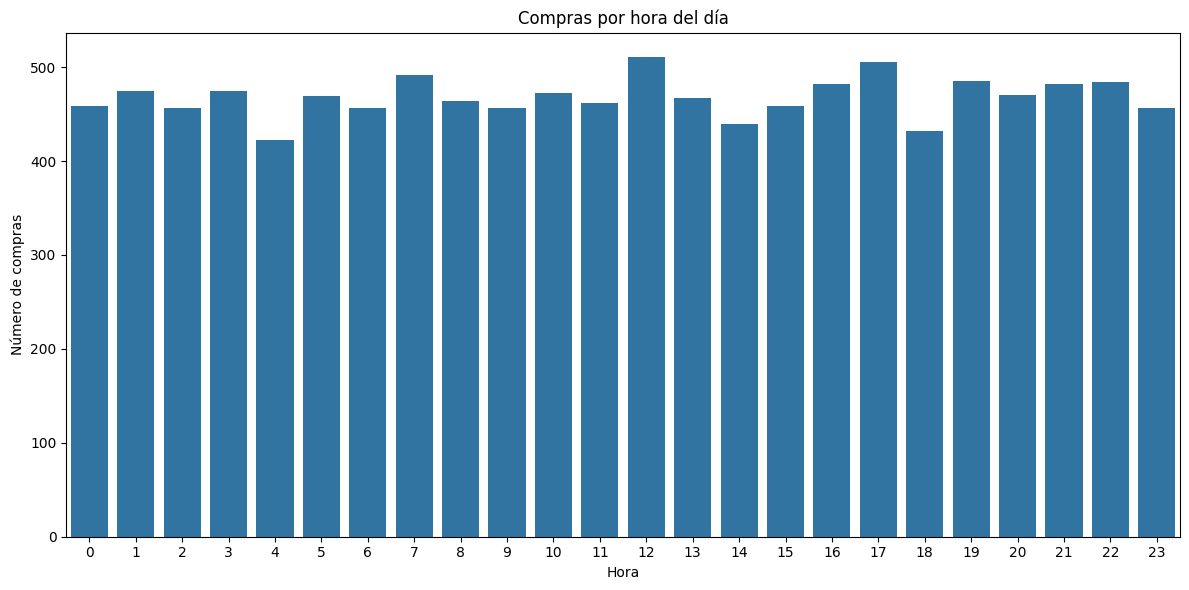

In [ ]:
df['Hora'] = pd.to_numeric(df['Hora'])  # Asegurar que sea numérico
ventas_por_hora = df.groupby('Hora').agg({
    'ID Compra': 'count',
    'Valor Total': 'sum'
})

print("Análisis de ventas por hora del día:")
print(ventas_por_hora.sort_values('ID Compra', ascending=False))

# Definir franjas horarias
df['Franja'] = pd.cut(
    df['Hora'],
    bins=[0, 6, 12, 18, 24],
    labels=['Madrugada (0-6h)', 'Mañana (6-12h)', 'Tarde (12-18h)', 'Noche (18-24h)']
)

ventas_por_franja = df.groupby('Franja').agg({
    'ID Compra': 'count',
    'Valor Total': 'sum'
})

print("\nAnálisis de ventas por franja horaria:")
print(ventas_por_franja)

# Análisis más detallado por categoría y hora
ventas_categoria_hora = df.groupby(['Categoría', 'Hora']).agg({
    'ID Compra': 'count',
    'Valor Total': 'sum'
}).reset_index()

print("\nMejores horas por categoría (top 3 para cada categoría):")
for categoria in df['Categoría'].unique():
    datos_categoria = ventas_categoria_hora[ventas_categoria_hora['Categoría'] == categoria]
    top_horas = datos_categoria.sort_values('ID Compra', ascending=False).head(3)
    print(f"\n{categoria}:")
    print(top_horas[['Hora', 'ID Compra', 'Valor Total']])

# Visualización (para dataset completo)
plt.figure(figsize=(12, 6))
sns.barplot(x=ventas_por_hora.index, y=ventas_por_hora['ID Compra'])
plt.title('Compras por hora del día')
plt.xlabel('Hora')
plt.ylabel('Número de compras')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('compras_por_hora.png')

10. ¿Se podrían automatizar alertas para compras inusuales?

In [ ]:
q1 = df['Cantidad'].quantile(0.25)
q3 = df['Cantidad'].quantile(0.75)
iqr = q3 - q1
limite_superior_cantidad = q3 + 1.5 * iqr

compras_inusuales_cantidad = df[df['Cantidad'] > limite_superior_cantidad]
print("Compras inusuales por cantidad:")
print(compras_inusuales_cantidad[['ID Compra', 'Nombre', 'Apellido', 'Electrodoméstico', 'Cantidad', 'Valor Total']])

# Detectar compras inusuales por valor
q1_valor = df['Valor Total'].quantile(0.25)
q3_valor = df['Valor Total'].quantile(0.75)
iqr_valor = q3_valor - q1_valor
limite_superior_valor = q3_valor + 1.5 * iqr_valor

compras_inusuales_valor = df[df['Valor Total'] > limite_superior_valor]
print("\nCompras inusuales por valor total:")
print(compras_inusuales_valor[['ID Compra', 'Nombre', 'Apellido', 'Electrodoméstico', 'Cantidad', 'Valor Total']])

# Detectar patrones inusuales por cliente
# Calcular estadísticas de compra por cliente
estadisticas_cliente = df.groupby(['Nombre', 'Apellido']).agg({
    'Valor Total': ['mean', 'std', 'max'],
    'Cantidad': ['mean', 'std', 'max']
})

# Implementar un sistema de puntuación para detectar anomalías
def calcular_score_anomalia(cliente_row, cliente_stats):
    nombre, apellido = cliente_row['Nombre'], cliente_row['Apellido']
    valor = cliente_row['Valor Total']
    cantidad = cliente_row['Cantidad']

    # Si no hay estadísticas previas, considerar como potencial anomalía
    if (nombre, apellido) not in cliente_stats.index:
        return 5

    stats = cliente_stats.loc[(nombre, apellido)]

    # Calcular desviaciones
    valor_mean, valor_std = stats[('Valor Total', 'mean')], stats[('Valor Total', 'std')]
    cant_mean, cant_std = stats[('Cantidad', 'mean')], stats[('Cantidad', 'std')]

    # Evitar división por cero
    valor_std = max(valor_std, valor_mean * 0.1)
    cant_std = max(cant_std, cant_mean * 0.1)

    z_valor = (valor - valor_mean) / valor_std
    z_cant = (cantidad - cant_mean) / cant_std

    # Calcular score de anomalía
    return max(abs(z_valor), abs(z_cant))

# Calcular score para cada compra
scores_anomalia = []
for _, row in df.iterrows():
    score = calcular_score_anomalia(row, estadisticas_cliente)
    scores_anomalia.append(score)

df['Score_Anomalia'] = scores_anomalia

# Identificar compras con alto score de anomalía
compras_anomalas = df[df['Score_Anomalia'] > 3].sort_values('Score_Anomalia', ascending=False)

print("\nCompras potencialmente anómalas (por patrón de cliente):")
print(compras_anomalas[['ID Compra', 'Nombre', 'Apellido', 'Electrodoméstico',
                         'Cantidad', 'Valor Total', 'Score_Anomalia']].head(10))

print("\nPosibles alertas a implementar:")
print("1. Alertas por compras con cantidad inusualmente alta")
print("2. Alertas por compras con valor total inusualmente alto")
print("3. Alertas por cambios drásticos en patrones de compra de un cliente")
print("4. Alertas por múltiples compras del mismo producto en un período corto")
print("5. Alertas por compras fuera del horario habitual del cliente")

Compras inusuales por cantidad:
Empty DataFrame
Columns: [ID Compra, Nombre, Apellido, Electrodoméstico, Cantidad, Valor Total]
Index: []

Compras inusuales por valor total:
      ID Compra     Nombre Apellido Electrodoméstico  Cantidad  Valor Total
0      CL-00001     Marcia    Parra           Nevera       5.0      9000000
4      CL-00005   Ambrosio     Prat         Lavadora       5.0      7500000
5      CL-00006     Roldán    Elías           Nevera       5.0      9000000
20     CL-00021   Florinda    Cases        Televisor       5.0      6000000
22     CL-00023     Salomé      Ros           Nevera       5.0      9000000
...         ...        ...      ...              ...       ...          ...
11199  CL-11200      Aarón   Peláez           Nevera       4.0      7200000
11209  CL-11210       Goyo    Plana           Nevera       3.0      5400000
11211  CL-11212      Maite  Torrent           Nevera       4.0      7200000
11212  CL-11213  Sebastián  Alcalde         Lavadora       5.0    